In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

import ipi_project as ipi
import experiments

Sinogram shape:  (1800, 972)
k = 1, com_k = 485.5 calc_com_k = 480.2596173601794, delta = 5.240382639820609
k = 2, com_k = 485.0 calc_com_k = 480.2737860201658, delta = 4.726213979834199
k = 3, com_k = 484.5 calc_com_k = 480.28787214026715, delta = 4.2121278597328455
k = 4, com_k = 484.0 calc_com_k = 480.30145716976904, delta = 3.698542830230963
k = 5, com_k = 483.5 calc_com_k = 480.31643071130753, delta = 3.1835692886924676
k = 6, com_k = 483.0 calc_com_k = 480.33145171282894, delta = 2.6685482871710633
k = 7, com_k = 482.5 calc_com_k = 480.3460003367278, delta = 2.1539996632722023
k = 8, com_k = 482.0 calc_com_k = 480.36005043375684, delta = 1.6399495662431605
k = 9, com_k = 481.5 calc_com_k = 480.37415169849334, delta = 1.1258483015066645
k = 10, com_k = 481.0 calc_com_k = 480.38789065407184, delta = 0.612109345928161
k = 11, com_k = 480.5 calc_com_k = 480.4018525591781, delta = 0.09814744082189009
k = 12, com_k = 480.0 calc_com_k = 480.4161143762443, delta = 0.4161143762443089
k = 

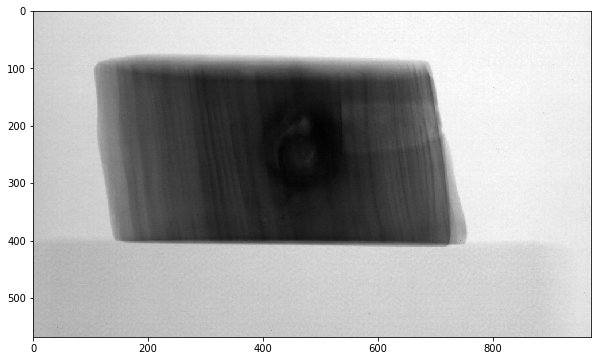

In [3]:
scans_directory = '/mnt/datasets1/fgustafsson/cwi_ct_scan/wooden_block/'
x, y = ipi.get_scan_image_dimension(scans_directory)

sinogram, images = ipi.load_images(scans_directory, slice_at=x//2)

max_angle = np.pi
sinogram = sinogram[0:sinogram.shape[0]//2]

scanned_angles = sinogram.shape[0]
scan_width = sinogram.shape[1]

first_image = skimage.io.imread(images[0])
print("Scan shape {} {}".format(x,y))
plt.figure(figsize = (10,10))
plt.imshow(first_image, cmap='gray')
proj_angles = np.linspace(0, (scanned_angles-1)*max_angle / scanned_angles, scanned_angles)

# SIRT Reconstruction

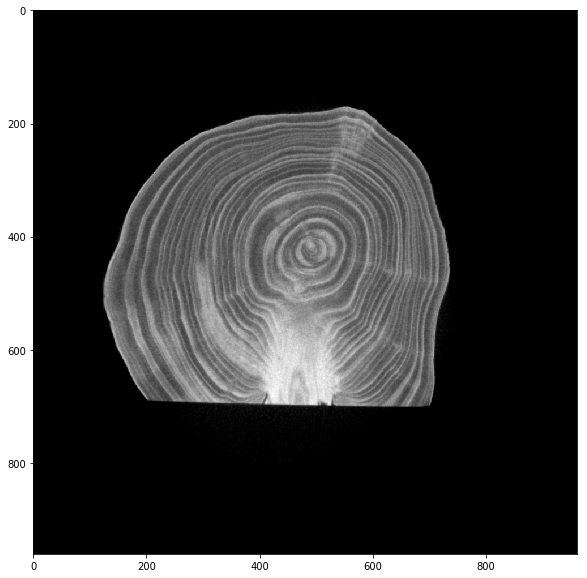

In [13]:
sirt_iter = 500
full_reconstruction = ipi.reconstruct_image_sirt(proj_angles,
                                                 sinogram,
                                                 sirt_iter)

plt.figure(figsize = (10,10))
plt.imshow(full_reconstruction, cmap='gray')

## Randomized trials: Best and worse reconstruction 
Pick $10$ angles at random and compare to baseline, repeat 500 times.

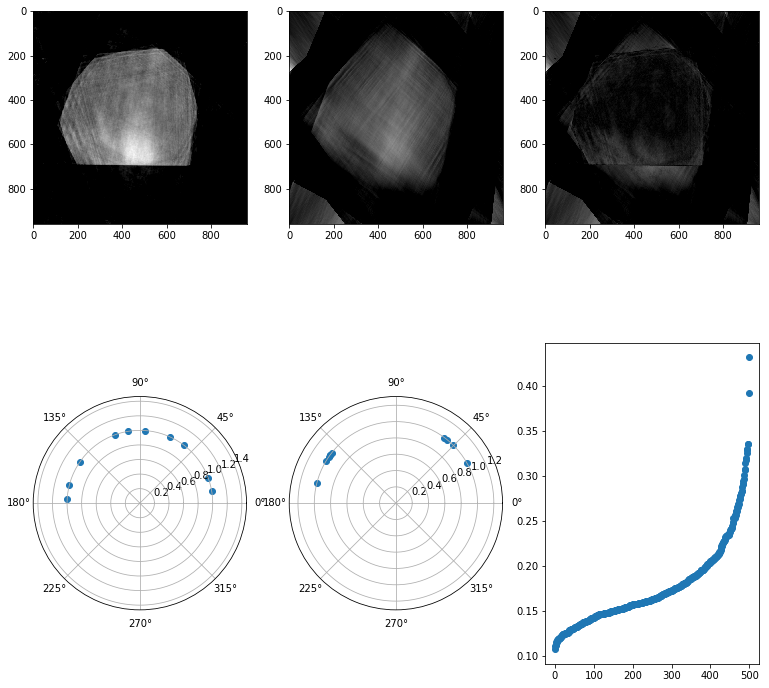

In [14]:
plt.figure(figsize=(13,13))
experiments.best_sparse_approximation(sinogram, proj_angles, sparse_size=10, trials=500)

## Experiment Angle selection: Gap angle vs  random angle
Select next projection angle with gap angle method vs picking a new random projection angle.



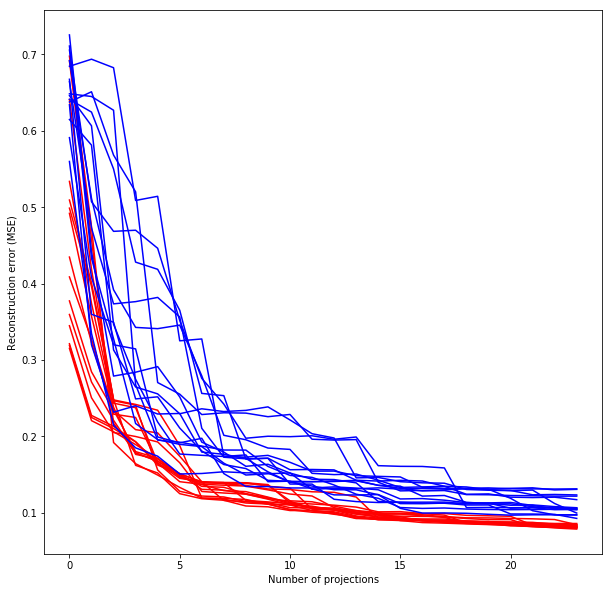

In [15]:
experiments.angle_selection_experiment(sinogram, proj_angles, max_angles=25, iterations=15)

## Assuming radial symmetry when reconstructing

Make one measurement and assume all other angles have the same data.

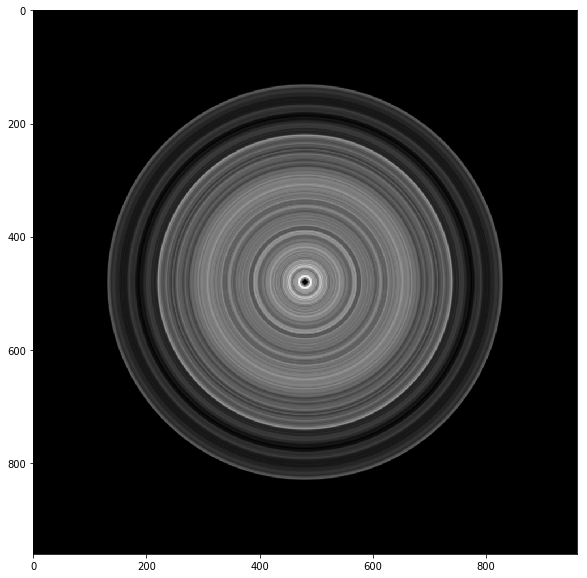

In [18]:
# Take the 100th projection and duplicate to all angles
sirt_iter = 500


proj_angles_2pi = np.linspace(0, 1799*2.0*np.pi/1800, 1800)
sinogram_repated = np.tile(sinogram[100], (1800,1))

all_same_reconstruction = ipi.reconstruct_image_sirt(proj_angles_2pi,
                                                     sinogram_repated,
                                                     sirt_iter)
plt.figure(figsize = (10,10))
plt.imshow(all_same_reconstruction, cmap='gray')

## Few (10) equally spaced angles

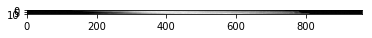

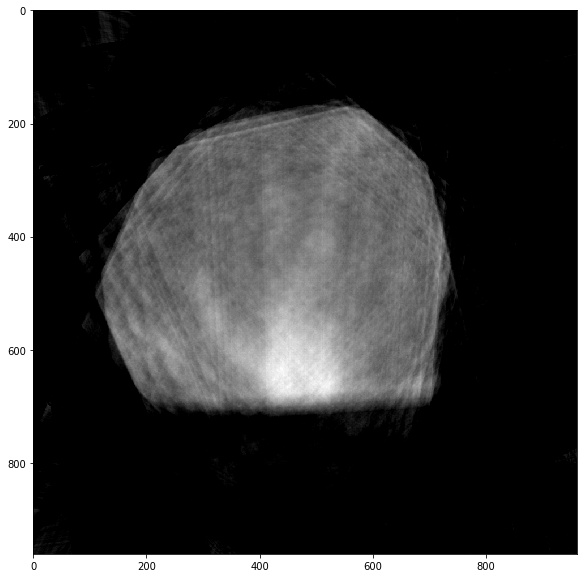

In [17]:
proj_angles = np.linspace(0, 180,10, endpoint=False)
sirt_iter = 100
reconstruction = experiments.angle_subset_reconstruction(sinogram, sirt_iter, proj_angles)
plt.figure(figsize = (10,10))
plt.imshow(reconstruction, cmap='gray')
plt.show()

## Use 40 equally spaced projections

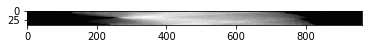

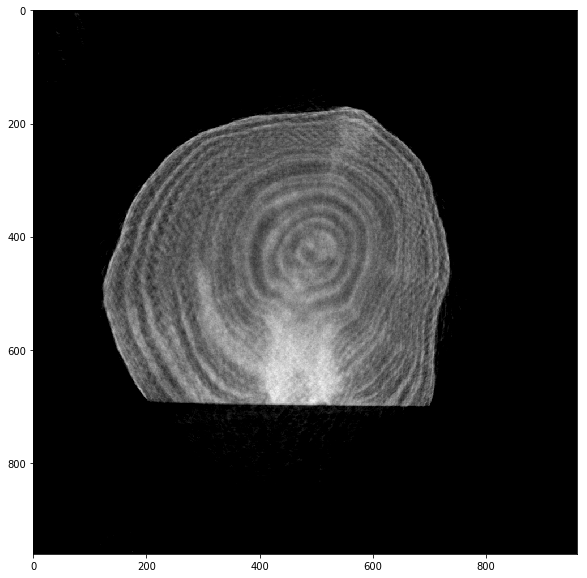

In [19]:
proj_angles = np.linspace(0, 180,40, endpoint=False)
reconstruction = experiments.angle_subset_reconstruction(sinogram, sirt_iter, proj_angles)
plt.figure(figsize = (10,10))
plt.imshow(reconstruction, cmap='gray')
plt.show()

## Reconstruction from 10 angles from a restricted range $\theta \in [0, 10^\circ]$

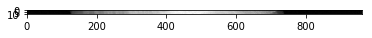

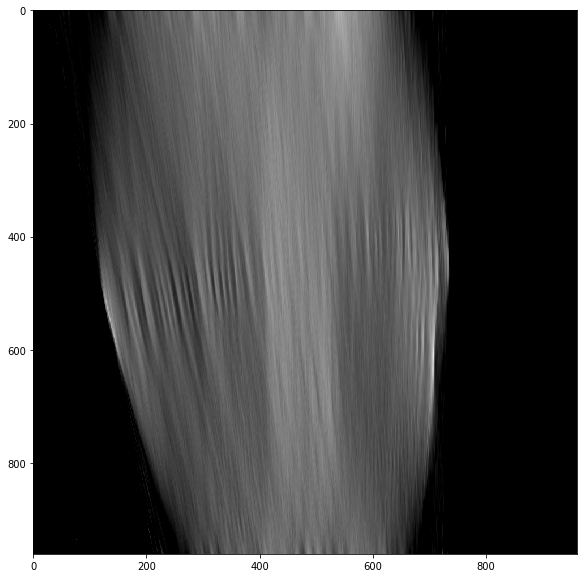

In [20]:
proj_angles = np.linspace(0, 10,10, endpoint=False)
reconstruction = experiments.angle_subset_reconstruction(sinogram, sirt_iter, proj_angles)
plt.figure(figsize = (10,10))
plt.imshow(reconstruction, cmap='gray')
plt.show()

## TV Inpainting of sinogram

Given a few known projections (the rows). Fill in the rest of the picture.

$$\min TV(U)$$

$$\text{subject to}\  U_{i,:} = r_i$$


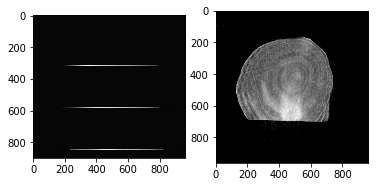

----------------------------------------------------------------------------
	SCS v2.0.2 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2017
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 4332497, CG tol ~ 1/iter^(2.00)
eps = 1.00e-05, alpha = 1.50, max_iters = 2000, normalize = 1, scale = 1.00
acceleration_lookback = 20, rho_x = 1.00e-03
Variables n = 1727940, constraints m = 3454020
Cones:	primal zero / dual free vars: 864900
	soc vars: 2589120, soc blks: 863040
Setup time: 2.52e-01s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0| 2.80e+00  4.07e+00  1.00e+00 -1.69e+05  1.09e+05  3.80e-11  1.13e+01 
   100| 1.01e-01  1.56e-01  1.63e-01  2.75e+03  1.98e+03  9.52e-11  4.09e+02 
   200| 9.39e-02  1.11e-01

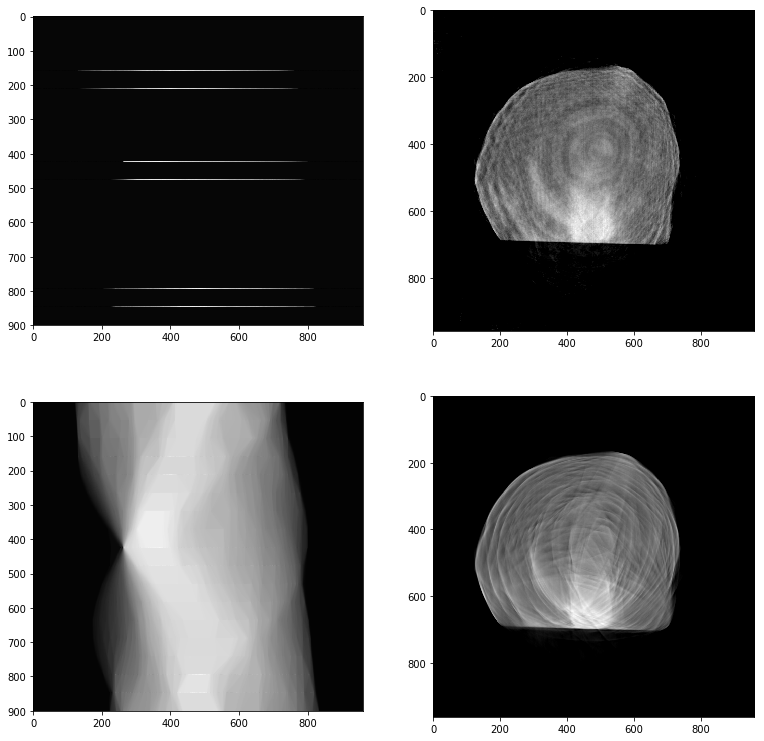

In [6]:
experiments.tv_inpaint_sinogram(sinogram, proj_angles, drop_rate=0.98)

# Compare with true sinogram

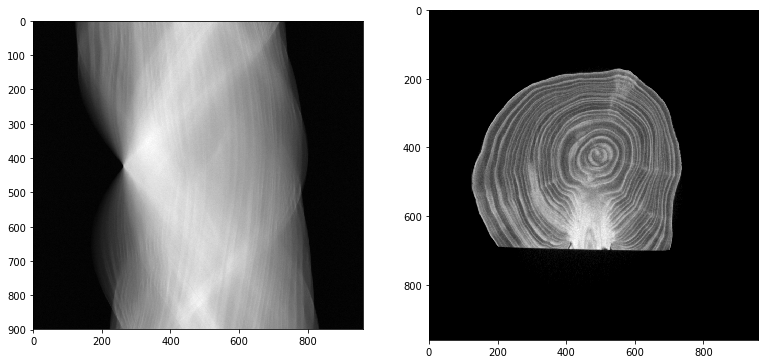

In [28]:
plt.figure(figsize=(13,6.5))
plt.subplot(121)
plt.imshow(sinogram, cmap='gray')
plt.subplot(122)
plt.imshow(full_reconstruction, cmap='gray')
plt.show()

## Reconstruction error when removing/ignorning segments
Start with a set of known projection $P$,
$$ P = \{\theta_1, \ldots, \theta_n\} $$

Drop one or several consective projections
$$ P_{(-i)} = P \backslash \{ \theta_i, \ldots, \theta_{i+k} \} $$

Compare the error
$$ || P_{(-i)} - P || $$ 

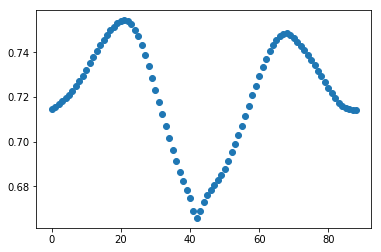

In [4]:
experiments.sinogram_degredation(sinogram, proj_angles)

## Reconstruction in polar form

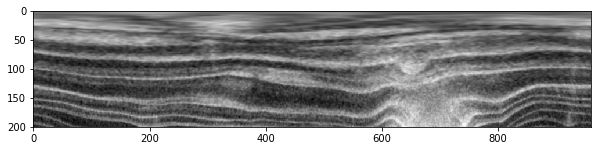

In [11]:
experiments.image2polar(sinogram, proj_angles)